# Requirements

In [ ]:
!pip install transformers
!pip install datasets
!pip install pytorch_metric_learning
!pip install opendatasets
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
address = "NLP_PROJECT/"
sys.path.append(f"/content/drive/My Drive/{address}")
%cd /content/drive/My\ Drive/$address

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/NLP_PROJECT


# Libraries

In [ ]:
import torch
from transformers import AutoProcessor, Wav2Vec2Model
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from pytorch_metric_learning.losses import ContrastiveLoss
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import os
from pydub import AudioSegment
import opendatasets as od
import pandas as pd
import gc
import random
import pickle
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Basic Pretrained Models

## Wav2Vec Model for Speech

In [ ]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

audio_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# audio file is decoded on the fly
inputs = audio_processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    outputs = audio_model(**inputs)

last_hidden_states = outputs.last_hidden_state.squeeze(0)
embeddings = last_hidden_states.mean(dim=0)
list(embeddings.shape)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[768]

## LaBSE Model for Text

In [ ]:
# import torch
# from transformers import BertModel, BertTokenizerFast


# tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
# text_model = BertModel.from_pretrained("setu4993/LaBSE")
# text_model = text_model.eval()

# english_sentences = [
#     "dog",
#     "Puppies are nice.",
#     "I enjoy taking long walks along the beach with my dog.",
# ]
# english_inputs = tokenizer(english_sentences, return_tensors="pt", padding=True)

# english_outputs = text_model(**english_inputs)
# pooled_embeddings = english_outputs.pooler_output
# pooled_embeddings.size()

torch.Size([3, 768])

## Bert Model for Text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_model = AutoModel.from_pretrained("bert-base-uncased")

sentence = "This is a test sentence."
inputs = tokenizer(sentence, return_tensors="pt")
outputs = text_model(**inputs)

embeddings = outputs.last_hidden_state.squeeze(0)
pooled_embeddings = embeddings.mean(dim=0)
pooled_embeddings.size()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([768])

# joint Encoder Model

## Model and Loss

In [ ]:
class JointNN(nn.Module):
    def __init__(self, in_features):
        super(JointNN, self).__init__()
        self.text_seq = nn.Sequential(
            nn.Linear(in_features, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Linear(576, 384),
        )
        self.audio_seq = nn.Sequential(
            nn.Linear(in_features, 576),
            nn.BatchNorm1d(576),
            nn.LeakyReLU(),
            nn.Linear(576, 384),
        )

    def forward(self, x_text, x_audio):
        x1 = self.text_seq(x_text)
        x2 = self.audio_seq(x_audio)
        return x1, x2

In [ ]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size=32, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Prepare Dataset

In [ ]:
dataset = load_dataset("asapp/slue", "voxpopuli")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
selected_dataset = dataset['train'].shuffle(0).select(range(60))

In [ ]:
texts = selected_dataset['normalized_text']
audios = [x["array"] for x in selected_dataset['audio']]

In [ ]:
text_embeddings = []
for text in tqdm(texts):
  inputs = tokenizer(text, return_tensors="pt")
  outputs = text_model(**inputs)

  embeddings = outputs.last_hidden_state.squeeze(0)
  pooled_embeddings = embeddings.mean(dim=0)
  text_embeddings.append(pooled_embeddings)

100%|██████████| 60/60 [00:08<00:00,  6.94it/s]


In [ ]:
audio_embeddings = []
for audio in tqdm(audios):
  inputs = audio_processor(audio, sampling_rate=sampling_rate, return_tensors="pt")
  with torch.no_grad():
      outputs = audio_model(**inputs)
  last_hidden_states = outputs.last_hidden_state.squeeze(0)
  embeddings = last_hidden_states.mean(dim=0)
  audio_embeddings.append(embeddings)

100%|██████████| 60/60 [03:15<00:00,  3.26s/it]


In [ ]:
len(text_embeddings)

60

In [ ]:
len(audio_embeddings)

60

In [ ]:
class MMDataSet(Dataset):
    def __init__(self, text_embeddings, audio_embeddings):
        self.text_embedings = text_embeddings
        self.audio_embeddings = audio_embeddings
        
    def __len__(self):
        return len(self.text_embedings)

    def __getitem__(self, i):
        return self.text_embedings[i], self.audio_embeddings[i]

## Train Test Split

In [ ]:
text_embedding_train, text_embedding_test, audio_embedding_train, audio_embedding_test = train_test_split(text_embeddings, audio_embeddings, test_size=0.2, random_state=42)

train_loader = DataLoader(dataset= MMDataSet(text_embedding_train, audio_embedding_train), batch_size=8, shuffle=True)
test_loader = DataLoader(dataset= MMDataSet(text_embedding_test, audio_embedding_test), batch_size=8, shuffle=False)

## Train Model

In [ ]:
model = JointNN(768).to(device)

In [ ]:
criterion = ContrastiveLoss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def eval_epoch(model: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader, test_mode=False):
    eval_loss = 0
    i = 0 

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (text_emb, audio_emb) in pbar:
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)
            text_final_emb, audio_final_emb = model(text_emb, audio_emb)

            batch_size = text_emb.shape[0]
            labels = torch.zeros(batch_size * batch_size)
            text_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])
            audio_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])

            for i in range(batch_size):
              for j in range(batch_size):
                text_embs_series[(batch_size * i) + j] = text_final_emb[i,:]
                audio_embs_series[(batch_size * i) + j] = audio_final_emb[j,:]
                if i == j:
                  labels[(batch_size * i) + j] = 1                    

            loss = criterion(text_embs_series,  labels, ref_emb=audio_embs_series)

            eval_loss += loss.item()

            discription = 'Validation' if not test_mode else 'Test'
            pbar.set_description(f'{discription} Loss: {loss.item():.4f}')
    return eval_loss

In [ ]:
import gc
gc.collect()

In [ ]:
num_epochs = 10

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    start_time = time()

    train_loss, val_loss = 0, 0
    epoch_all = 0
    epoch_true = 0
    i = 0

    model.train()
    
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (text_emb, audio_emb) in pbar:    
            text_emb = text_emb.to(device)
            audio_emb = audio_emb.to(device)


            text_final_emb, audio_final_emb = model(text_emb, audio_emb)
            
            batch_size = text_emb.shape[0]
            labels = torch.zeros(batch_size * batch_size)
            text_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])
            audio_embs_series = torch.zeros(batch_size * batch_size, text_final_emb.shape[1])

            for i in range(batch_size):
              for j in range(batch_size):
                text_embs_series[(batch_size * i) + j] = text_final_emb[i,:]
                audio_embs_series[(batch_size * i) + j] = audio_final_emb[j,:]
                if i == j:
                  labels[(batch_size * i) + j] = 1                

            loss = criterion(text_embs_series,  labels, ref_emb=audio_embs_series)
            
            train_loss += loss.item()

            pbar.set_description(f'Loss: {loss.item():.4f}')

            loss.backward(retain_graph=True)

            optimizer.step()
            optimizer.zero_grad()  
  
    model.eval()
    
    val_loss = eval_epoch(model, criterion, test_loader)
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(test_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    end_time = time()
    
    print(f'Epoch {epoch + 1} finished in {end_time - start_time:.2f}s')

    print(f"[Epoch {epoch + 1}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

Validation Loss: 1.4396: 100%|██████████| 2/2 [00:00<00:00, 138.91it/s]


Epoch 1 finished in 18.26s
[Epoch 1]	Train Loss: 0.1738	Validation Loss: 0.2397


Validation Loss: 1.4086: 100%|██████████| 2/2 [00:00<00:00, 121.85it/s]


Epoch 2 finished in 18.63s
[Epoch 2]	Train Loss: 0.1709	Validation Loss: 0.2349


Validation Loss: 1.3793: 100%|██████████| 2/2 [00:00<00:00, 155.23it/s]


Epoch 3 finished in 18.32s
[Epoch 3]	Train Loss: 0.1678	Validation Loss: 0.2299


Validation Loss: 1.3477: 100%|██████████| 2/2 [00:00<00:00, 145.81it/s]


Epoch 4 finished in 19.88s
[Epoch 4]	Train Loss: 0.1648	Validation Loss: 0.2241


Validation Loss: 1.3157: 100%|██████████| 2/2 [00:00<00:00, 165.39it/s]


Epoch 5 finished in 20.04s
[Epoch 5]	Train Loss: 0.1615	Validation Loss: 0.2183


Validation Loss: 1.2850: 100%|██████████| 2/2 [00:00<00:00, 158.87it/s]


Epoch 6 finished in 17.94s
[Epoch 6]	Train Loss: 0.1584	Validation Loss: 0.2128


Validation Loss: 1.2583: 100%|██████████| 2/2 [00:00<00:00, 151.81it/s]


Epoch 7 finished in 18.02s
[Epoch 7]	Train Loss: 0.1549	Validation Loss: 0.2080


Validation Loss: 1.2334: 100%|██████████| 2/2 [00:00<00:00, 165.73it/s]


Epoch 8 finished in 19.03s
[Epoch 8]	Train Loss: 0.1519	Validation Loss: 0.2036


Validation Loss: 1.2099: 100%|██████████| 2/2 [00:00<00:00, 141.93it/s]


Epoch 9 finished in 17.90s
[Epoch 9]	Train Loss: 0.1481	Validation Loss: 0.1996


Validation Loss: 1.1864: 100%|██████████| 2/2 [00:00<00:00, 136.48it/s]

Epoch 10 finished in 17.95s
[Epoch 10]	Train Loss: 0.1448	Validation Loss: 0.1956


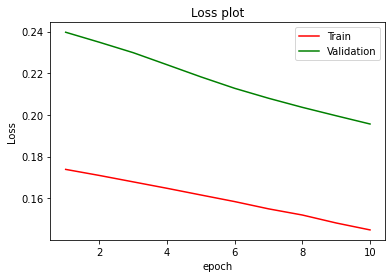

In [ ]:
ls_epoch = [_ + 1 for _ in range(num_epochs)]
plt.plot(ls_epoch, train_loss_arr, color='r', label='Train')
plt.plot(ls_epoch, val_loss_arr, color='g', label='Validation')
plt.title('Loss plot')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()  

## Save Model

In [ ]:
PATH = "multimodal_model.pt"

# Save
torch.save(model, PATH)

In [ ]:
# Load
PATH = "multimodal_model.pt"
model = torch.load(PATH)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
dataset = load_dataset("asapp/slue", "voxpopuli")
selected_dataset = dataset['test'].shuffle(0).select(range(20))
texts = selected_dataset['normalized_text']
audios = [x["array"] for x in selected_dataset['audio']]

/root/.cache/huggingface/datasets/downloads/extracted/0b34d0c91a12aee42c42de5564d3e0be85f23f00a5c3ed46654c9d1f4f27c8af/slue-voxpopuli


Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1753 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1842 [00:00<?, ? examples/s]

Dataset slue downloaded and prepared to /root/.cache/huggingface/datasets/asapp___slue/voxpopuli/2.4.0/6eef0a9b9ce2693a4f0ffdf4dd74ab5dc6e95bcd07366ac2a2b275a5b296f90d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Wrapper Model for Meausring Similiarty
This Model gets a text query and list of audios as an input and returned a list which shows which audios are related to that query.

In [ ]:
class SimilarityModel:
    def __init__(self, path_to_multimodal_model, sampling_rate=16000, threshold=0.5):
      self.audio_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
      self.audio_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
      self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
      self.text_model = AutoModel.from_pretrained("bert-base-uncased")
      self.threshold = threshold
      self.nn_model = torch.load(path_to_multimodal_model)
      self.nn_model.eval()
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.nn_model = self.nn_model.to(self.device)
      self.sampling_rate = sampling_rate

    def cosine_similarity(self, embedding1, embedding2):
      dim = 1
      embedding1 = F.normalize(embedding1, p=2, dim=dim)
      embedding2 = F.normalize(embedding2, p=2, dim=dim)

      dot_product = torch.sum(embedding1 * embedding2, dim=dim)

      magnitude1 = torch.norm(embedding1, p=2, dim=dim)
      magnitude2 = torch.norm(embedding2, p=2, dim=dim)

      cosine_sim = dot_product / (magnitude1 * magnitude2)

      return cosine_sim

    def predict(self, audios, texts, threshold=None, is_query=False):
      audio_embs = []
      for audio in tqdm(audios):
        inputs = self.audio_processor(audio, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True)
        outputs = self.audio_model(**inputs)
        last_hidden_states = outputs.last_hidden_state.squeeze(0)
        audio_embedding = last_hidden_states.mean(dim=0)
        audio_embs.append(audio_embedding)

      text_embs = []
      for text in texts:
        inputs = self.tokenizer(text, return_tensors="pt")
        outputs = self.text_model(**inputs)
        embedding = outputs.last_hidden_state.squeeze(0)
        text_embedding = embedding.mean(dim=0)
        text_embs.append(text_embedding)
      if is_query:
        item = text_embs[0]
        for i in range(len(audios) - 1):
          text_embs.append(item.clone())


      audio_embedding = torch.stack(audio_embs)
      text_embedding = torch.stack(text_embs)
      text_embedding = text_embedding.to(self.device)
      audio_embedding = audio_embedding.to(self.device)

      text_final_emb, audio_final_emb = self.nn_model(text_embedding, audio_embedding)
      cosine_similarity = self.cosine_similarity(text_final_emb, audio_final_emb)
      print(cosine_similarity)

      final_threshold = threshold if threshold else self.threshold

      return (cosine_similarity >= final_threshold).int()

    def retrieve_relevant_audios(self, audios, query, threshold=None):
      return self.predict(audios, [query], is_query=True, threshold=threshold)

In [ ]:
import gc
gc.collect()

30

In [ ]:
PATH = "multimodal_model.pt"

final_model = SimilarityModel(PATH)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predi

In [ ]:
final_model.predict(audios[10:16], texts[10:16])

100%|██████████| 6/6 [00:28<00:00,  4.77s/it]


tensor([0.3168, 0.3256, 0.3351, 0.3646, 0.2694, 0.2816], device='cuda:0',
       grad_fn=<DivBackward0>)


tensor([0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [ ]:
final_model.retrieve_relevant_audios(audios[4:7], texts[4])

100%|██████████| 3/3 [00:08<00:00,  2.85s/it]


tensor([0.1886, 0.2635, 0.2610], device='cuda:0', grad_fn=<DivBackward0>)


tensor([0, 0, 0], device='cuda:0', dtype=torch.int32)

## Finding Best Hyper Parameters and Testing Model

In [ ]:
# find best hyperparameter

size = len(audios)
labels = []
text_series = []
audio_series = []

for i in range(size):
  for j in range(size):
    text_series.append(texts[i])
    audio_series.append(audios[j])
    labels.append(1 if i == j else 0)              

In [ ]:
def accuracy_of_model(model, audios, texts, labels, threshold):
  result = model.predict(audios, texts, threshold=threshold)
  accuracy = accuracy_score(result.detach().cpu(), labels)
  return accuracy

In [ ]:
threshold_list = [0.05 * i for i in range(2,13)]
best_accuracy = 0
best_threshold = 0
for threshold in threshold_list:
  accuracy = accuracy_of_model(final_model, audio_series[:5], text_series[:5], labels[:5], threshold)
  print(f"Accuracy with threshold {threshold}:.2f = {accuracy * 100}:.2f%")
  if accuracy > best_accuracy:
    best_threshold = threshold
    best_accuracy = accuracy
  gc.collect()

print(f"Best threshold is {best_threshold}")
print(f"Best accuracy is {best_accuracy}")

100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.1 = 0.2


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.15000000000000002 = 0.2


100%|██████████| 5/5 [00:18<00:00,  3.73s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.2 = 0.2


100%|██████████| 5/5 [00:25<00:00,  5.02s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.25 = 0.2


100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.30000000000000004 = 0.0


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.35000000000000003 = 0.6


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.4 = 0.8


100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.45 = 0.8


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.5 = 0.8


100%|██████████| 5/5 [00:18<00:00,  3.80s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.55 = 0.8


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


tensor([0.2986, 0.3014, 0.3206, 0.3550, 0.3282], device='cuda:0',
       grad_fn=<DivBackward0>)
Accuracy with threshold 0.6000000000000001 = 0.8
Best threshold is 0.4
Best accuracy is 0.8


In [ ]:
PATH = "multimodal_model.pt"
best_model = SimilarityModel(PATH, threshold=best_threshold)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predi

## Save Model

In [ ]:
PATH = "final_relevant_model.pt"

# Save
torch.save(best_model, PATH)

In [ ]:
# Load
PATH = "final_relevant_model.pt"
best_model = torch.load(PATH)
best_model

In [ ]:
best_model.device

device(type='cuda')

## Evaluation

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
dataset = load_dataset("asapp/slue", "voxpopuli")
selected_dataset = dataset['test'].shuffle(0).select(range(20))
texts = selected_dataset['normalized_text']
audios = [x["array"] for x in selected_dataset['audio']]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
size = len(audios)
labels = []
text_series = []
audio_series = []

for i in range(size):
  for j in range(size):
    text_series.append(texts[i])
    audio_series.append(audios[j])
    labels.append(1 if i == j else 0) 

In [ ]:
zipped_lists = list(zip(audio_series, text_series, labels))

n = 20
sampled_tuples = random.sample(zipped_lists, n)

# unzip the sampled tuples into separate lists
audios_test, texts_test, labels_test = zip(*sampled_tuples)

In [ ]:
r = best_model.predict(audios_test[1:3], texts_test[1:3])
type(r)

100%|██████████| 2/2 [00:32<00:00, 16.34s/it]


tensor([0.3812, 0.3114], device='cuda:0', grad_fn=<DivBackward0>)


torch.Tensor

In [ ]:
a = [1,2]
a.extend(r.detach().cpu().tolist())
a[0:5]

[1, 2, 0, 0]

In [ ]:
len(labels_test)

20

In [ ]:
final_result = []
step_size = 4
for i in range(n // step_size):
  result = best_model.predict(audios_test[i * step_size: (i + 1) * step_size], texts_test[i * step_size: (i + 1) * step_size])
  final_result.extend(result.detach().cpu().tolist())
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.ipc_collect()

100%|██████████| 4/4 [00:19<00:00,  4.85s/it]


tensor([0.2783, 0.2966, 0.2043, 0.2510], device='cuda:0',
       grad_fn=<DivBackward0>)


100%|██████████| 4/4 [00:31<00:00,  7.83s/it]


tensor([0.2729, 0.2694, 0.3053, 0.3614], device='cuda:0',
       grad_fn=<DivBackward0>)


100%|██████████| 4/4 [00:21<00:00,  5.30s/it]


tensor([0.2195, 0.3375, 0.2782, 0.3196], device='cuda:0',
       grad_fn=<DivBackward0>)


100%|██████████| 4/4 [00:21<00:00,  5.40s/it]


tensor([0.3420, 0.2843, 0.3642, 0.3199], device='cuda:0',
       grad_fn=<DivBackward0>)


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


tensor([0.3119, 0.2715, 0.2492, 0.3175], device='cuda:0',
       grad_fn=<DivBackward0>)


In [ ]:
accuracy = accuracy_score(final_result, labels_test)
accuracy

0.95

In [ ]:
gc.collect()

464

In [ ]:
true_labels = labels_test
predicted_labels = final_result

f1_macro = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1-Macro: {round(f1_macro, 3)}\n")

f1_micro = f1_score(true_labels, predicted_labels, average='micro')
print(f"F1-Micro: {round(f1_micro, 3)}\n")


confusion_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(2))
confusion_mat_df = pd.DataFrame(confusion_mat)
display(confusion_mat_df)

F1-Macro: 0.487

F1-Micro: 0.95



,0,1
0,19,0
1,1,0


In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Macro-average precision: {:.2f}".format(precision))
print("Macro-average recall: {:.2f}".format(recall))
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
print("Micro-average precision: {:.2f}".format(precision))
print("Micro-average recall: {:.2f}".format(recall))

Macro-average precision: 0.47
Macro-average recall: 0.50
Micro-average precision: 0.95
Micro-average recall: 0.95


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Create Main Dataset

## Load Dataset and preprocess

In [ ]:
od.download('https://www.kaggle.com/datasets/benimaru069/librispeech-small-dataset')

#It needes enter your kaggle user name and key.

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading librispeech-small-dataset.zip to ./librispeech-small-dataset


100%|██████████| 13.7G/13.7G [01:48<00:00, 136MB/s]


In [ ]:
df = pd.read_csv('metadata_RAKE.csv')

In [ ]:
df[['sentence','audio_path','count','key_word_1','key_word_2', 'key_word_3', 'key_word_4', 'key_word_5']]

,sentence,audio_path,count,key_word_1,key_word_2,key_word_3,key_word_4,key_word_5
0,BUT WHEN HE CAME TO THE STY THERE WAS NO PIG T...,../input/librispeech-asr-wav-dataset/train-cle...,11.0,came,sty,pig,seen,searched
1,AND SO HE WENT SOFTLY UP TO THE PIG STY AND RE...,../input/librispeech-asr-wav-dataset/train-cle...,15.0,went,softly,pig,sty,reached
2,THE FARMER GAVE ME NOTHING BUT A SCOLDING BUT ...,../input/librispeech-asr-wav-dataset/train-cle...,16.0,farmer,gave,nothing,scolding,nice
3,AH YOU CAN RUN ABOUT ALL DAY IN SUMMER AND IN ...,../input/librispeech-asr-wav-dataset/train-cle...,17.0,ah,run,day,summer,winter
4,IT WAS ONE MORNING AFTER CHRISTMAS SAID THE RA...,../input/librispeech-asr-wav-dataset/train-cle...,26.0,one,morning,christmas,said,rabbit
...,...,...,...,...,...,...,...,...
45532,A PERSON OF GREATER ENTERPRISE THAN DISCRETION...,../input/librispeech-asr-wav-dataset/train-cle...,10.0,person,greater,enterprise,discretion,embracing
45533,TO THE UNSPEAKABLE ENHANCEMENT OF THE LUCIDITY...,../input/librispeech-asr-wav-dataset/train-cle...,6.0,unspeakable,enhancement,lucidity,thought,value
45534,A PAGEANT WHEREBY WE ATTEST OUR RESPECT FOR TH...,../input/librispeech-asr-wav-dataset/train-cle...,7.0,pageant,whereby,attest,respect,dead
45535,WE OBSERVE THE SAME THING IN CHILDREN TO DAY,../input/librispeech-asr-wav-dataset/train-cle...,4.0,observe,thing,children,day,NaN


In [ ]:
df.iloc()[29]

audio_path      ../input/librispeech-asr-wav-dataset/train-cle...
filename                                      100-121669-0012.wav
subset                                            train-clean-360
speaker_id                                                    100
chapter_id                                                 121669
file_id                                                        12
id                                                100-121669-0012
sex                                                             F
minute                                                      25.06
speaker_name                                          Judy Bieber
sentence        THE FARMER HAD STOPPED SAWING TO REST JUST THE...
count                                                        21.0
key_word_1                                                 farmer
key_word_2                                                stopped
key_word_3                                                 sawing
key_word_4

In [ ]:
df['keywords'] = df[['key_word_1', 'key_word_2', 'key_word_3', 'key_word_4', 'key_word_5']].apply(lambda x: ' '.join([str(i) for i in x if not pd.isna(i)]), axis=1)
df = df.drop(columns=['key_word_1', 'key_word_2', 'key_word_3', 'key_word_4', 'key_word_5'])
df.head()

,audio_path,filename,subset,speaker_id,chapter_id,file_id,id,sex,minute,speaker_name,sentence,count,keywords
0,../input/librispeech-asr-wav-dataset/train-cle...,100-121669-0019.wav,train-clean-360,100,121669,19,100-121669-0019,F,25.06,Judy Bieber,BUT WHEN HE CAME TO THE STY THERE WAS NO PIG T...,11.0,came sty pig seen searched
1,../input/librispeech-asr-wav-dataset/train-cle...,100-121669-0014.wav,train-clean-360,100,121669,14,100-121669-0014,F,25.06,Judy Bieber,AND SO HE WENT SOFTLY UP TO THE PIG STY AND RE...,15.0,went softly pig sty reached
2,../input/librispeech-asr-wav-dataset/train-cle...,100-121669-0013.wav,train-clean-360,100,121669,13,100-121669-0013,F,25.06,Judy Bieber,THE FARMER GAVE ME NOTHING BUT A SCOLDING BUT ...,16.0,farmer gave nothing scolding nice
3,../input/librispeech-asr-wav-dataset/train-cle...,100-121674-0035.wav,train-clean-360,100,121674,35,100-121674-0035,F,25.06,Judy Bieber,AH YOU CAN RUN ABOUT ALL DAY IN SUMMER AND IN ...,17.0,ah run day summer winter
4,../input/librispeech-asr-wav-dataset/train-cle...,100-121674-0017.wav,train-clean-360,100,121674,17,100-121674-0017,F,25.06,Judy Bieber,IT WAS ONE MORNING AFTER CHRISTMAS SAID THE RA...,26.0,one morning christmas said rabbit


In [ ]:
len(df)

45537

In [ ]:
df.iloc()[0]['keywords']

'came sty pig seen searched'

In [ ]:
audio_file = AudioSegment.from_file('librispeech-small-dataset/wavs/100-121669-0013.wav')
audio_file

In [ ]:
data = []
path = 'librispeech-small-dataset/wavs/'

for i in tqdm(range(len(df))):
    file_path = path + df.iloc()[i]['audio_path'].split('/')[-1]
    data.append((file_path, df.iloc()[i]['keywords']))

100%|██████████| 45537/45537 [00:44<00:00, 1016.02it/s]


In [ ]:
samples = np.array(audio_file.get_array_of_samples())

samples = samples.reshape(-1, audio_file.channels)

samples = samples / np.max(np.abs(samples))


samples = samples.squeeze()
samples.shape

(53440,)

In [ ]:
audio_file.frame_rate

16000

In [ ]:
selected_data = random.sample(data, 4500)

In [ ]:
del data
gc.collect()

16

## Create final dataset
We create a dataset which contains waveform of a large audio with its corresponding keywords.

In [ ]:
audios_dataset = []
keywords_dataset = []
c = 0
for file, keywords in tqdm(selected_data):
  try:
    audio_file = AudioSegment.from_file(file)
    samples = np.array(audio_file.get_array_of_samples())
    samples = samples.reshape(-1, audio_file.channels)
    samples = samples / np.max(np.abs(samples))
    samples = samples.squeeze()
    audios_dataset.append(samples)
    keywords_dataset.append(keywords)
  except Exception as e:
    continue
  c += 1
  gc.collect()
  if c == 3000:
    break

 84%|████████▎ | 3760/4500 [31:11<06:08,  2.01it/s]


In [ ]:
gc.collect()

603

In [ ]:
type(audios_dataset[0])

numpy.ndarray

In [ ]:
audios_dataset = np.array(audios_dataset)

<ipython-input-37-75ade9f184bd>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audios_dataset = np.array(audios_dataset)


## Save Dataset

In [ ]:
np.save('audios_dataset.npy', audios_dataset)

In [ ]:
import pickle

with open('keywords_dataset.pkl', 'wb') as f:
    pickle.dump(keywords_dataset, f)

In [ ]:
os.path.getsize('audios_dataset.npy')

4787335098

In [ ]:
from google.colab import files
files.download("audios_dataset.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Loading list from a file
with open('keywords_dataset.pkl', 'rb') as f:
    keywords_dataset = pickle.load(f)
len(keywords_dataset)

3000

In [ ]:
audios_dataset = np.load('audios_dataset.npy', allow_pickle=True)
len(audios_dataset)

3000

In [ ]:
gc.collect()

53